# Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

With the boom of cheap airplane tickets, tourists from around the world are given the chance to explore more destinations more than ever. Most people want to make the most of their holidays so they travel to the most popular destinations. But traveling to popular destinations themselves doesn't simply makes the most of our off days.

Any traveler wants to make the most of their travels. One problem arising in planning travels is maximing your travel days to explore popular areas in your destination. This is made easier today by online guides and maps but they don't tell a complete picture on where exactly the popular areas are.

One possible solution for this is the application of K-means clustering of popular places a specific destination. Tourists are now given clusters of places wherein they can easily plan ahead on when and where to go on their travel days.

In this project, our destination of interest would be on **Kowloon City District, Hong Kong**.

## Data <a name="data"></a>

Based on the definition of the problem, our main factors would be:

- distance of top tourist spots from the city center
- ratings of the top tourist spots

Following data sources will be needed to extract/generate the required information:

- venues and their type and location within a specific radius will be obtained using **Foursquare API**
- coordinate of Kowloon City District center will be obtained using **Nominatim** library

### Nominatim

Since we're interested in getting data regarding the **Kowloon City District**, we first obtain it's geospatial coordinates. We can do that by firing up `geolocator`.

In [5]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Kowloon City District, Hong Kong'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude,",",longitude)

22.32179955 , 114.18859418638175


### Foursquare API

Now that we have our coordinates. We now obtain the top venues for the selected destination. Due to Premium API limitations, we are only able to obtain a maximum of the top 50 picks.

In [15]:
#imports
import requests
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [142]:
# The code was removed by Watson Studio for sharing.

After obtaining the results from the API, we then continue on cleaning the data.

In [36]:
# Function to extract desired data
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [215]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id', 'venue.location.distance']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,id,distance
0,Lazy Creatures (慵懶生物),Café,22.327093,114.188935,5c1e35dd65cdf80039d73b81,590
1,Kung Wo Dou Bun Chong (公和荳品廠),Dessert Shop,22.329728,114.187646,4c90b2812626a1cd45852b6b,887
2,The Mahjong Hostel (麻雀客棧),Hostel,22.320208,114.187643,54a4d266498e51ca1d73cf74,202
3,Islam Food (清真牛肉館),Halal Restaurant,22.328211,114.190391,4c024906cbd876b0ad15f143,737
4,Kowloon Walled City Park (九龍寨城公園),Park,22.331995,114.190401,4b0588d4f964a520e5db22e3,1150


The top 5 nearest venues are shown above.

We then continue on to obtain further details about each of the venue.

In [141]:
# Function for getting details for each venue
def getDetails(ids):
    venues_list=[]
    for id in zip(ids):
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            id[0],
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        results = requests.get(url).json()["response"]
        venues_list.append([(
            id[0],
            results['venue']['rating']
        )])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['id', 'rating']
    
    return(nearby_venues)
    

In [144]:
nearby_venues_details = getDetails(ids=nearby_venues['id'])
nearby_venues_details.head()

,id,rating
0,5c1e35dd65cdf80039d73b81,8.3
1,4c90b2812626a1cd45852b6b,8.7
2,54a4d266498e51ca1d73cf74,7.9
3,4c024906cbd876b0ad15f143,8.1
4,4b0588d4f964a520e5db22e3,8.7


Now we have the datasets we need.

## Methodology <a name="methodology"></a>

In this project, we'll focus on clustering venues which are closest to each other and rank them according to their rating.

In the first step, we were able to obtain the geocoordinates for **Kowloon City District**. We have also obtained the top 50 picks of nearby places, distance from the city center, and rating through the **Foursquare API**.

For the next step in our Analysis, we examine the data by presenting a scatter plot of the venus according to distance from the city center. This is for us to have a clearer picture of the dataset at hand.

Lastly, would be to group of the venues through K-means clustering. The value K would be set according to the length of stay of a particular tourist.

## Analysis <a name="analysis"></a>

 Let's perform some basic visualization of the datasets we have gathered so far. We will look for a correlation between the distance of a venue to it's rating.

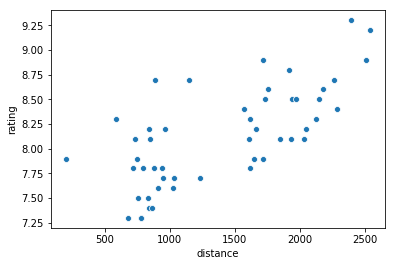

In [123]:
import seaborn as sns

sns.scatterplot(x=nearby_venues['distance'], y=nearby_venues_details['rating'])

Notice that we can see a positive relationship on our scatter plot. Farther venues tend to have higher ratings as compared to those that are near.

Having observed this kind of relationship, we expect that our clusters would include venues of similar ratings. Let's continue on our clustering to find out.

In this project, K can be set according to the number of day/s a particular tourist would stay. This is to assume that the tourist would stay a minimum of 2 days. For this example, we use `k=3`.

In [216]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 3

nearby_venues_clustering = nearby_venues.drop(['name','categories','id','distance'],1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_venues_clustering)

We now merge our datasets, top 50 venues and their details, and our k-clusters.

In [217]:
# We fit the clusters to our data frame
try:
    nearby_venues.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    print('Cluster Labels already exist')
    
df_merged = nearby_venues.join(nearby_venues_details.set_index('id'), on='id')

df_merged

,Cluster Labels,name,categories,lat,lng,id,distance,rating
0,1,Lazy Creatures (慵懶生物),Café,22.327093,114.188935,5c1e35dd65cdf80039d73b81,590,8.3
1,1,Kung Wo Dou Bun Chong (公和荳品廠),Dessert Shop,22.329728,114.187646,4c90b2812626a1cd45852b6b,887,8.7
2,1,The Mahjong Hostel (麻雀客棧),Hostel,22.320208,114.187643,54a4d266498e51ca1d73cf74,202,7.9
3,1,Islam Food (清真牛肉館),Halal Restaurant,22.328211,114.190391,4c024906cbd876b0ad15f143,737,8.1
4,1,Kowloon Walled City Park (九龍寨城公園),Park,22.331995,114.190401,4b0588d4f964a520e5db22e3,1150,8.7
5,1,Kowloon City Market (九龍城街市),Market,22.329359,114.189015,4c53c43e72cf0f47cd906bd3,842,8.2
6,1,Woo Cow Hotpot (禾牛薈火鍋館),Hotpot Restaurant,22.329366,114.189867,4b508503f964a520ea2527e3,852,8.1
7,1,Tak Cheong Noodle (德昌魚蛋粉),Noodle House,22.330406,114.187617,4b0d3533f964a520944423e3,963,8.2
8,1,Hop Shing Dessert (合成糖水),Dessert Shop,22.328387,114.190197,4b7a8bc5f964a5209d302fe3,751,7.9
9,1,Rings Coffee,Coffee Shop,22.328186,114.189370,5a34b000e96d0c078036e0b3,715,7.8


After obtaining our merged data frame, we visualize the clustering on a map.

In [218]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 10, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['lat'], df_merged['lng'], df_merged['name'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Further information about the clusters are showed below. Venues were sorted according to rating

#### Cluster 0

In [197]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(2, df_merged.shape[1]))]].sort_values(by=['rating'],ascending=False)

,name,categories,lat,lng,id,distance,rating
44,Hotel ICON (唯港薈),Hotel,22.300801,114.179720,4d26701677a2a1cde9bf4fb7,2509,8.9
18,Wonderland Superstore (奇趣天地),Toy / Game Store,22.304615,114.188014,54923e4e498e6cfc14ca52da,1913,8.8
32,Kerry Hotel Hong Kong (香港嘉里酒店),Hotel,22.301454,114.188875,58816f6289151d6db3e3e6c9,2265,8.7
24,Old Man Hot Pot (老坑火鍋),Hotpot Restaurant,22.308055,114.183641,4c18bc2d1436a593fdaf8d75,1612,8.1


#### Cluster 1

In [198]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(2, df_merged.shape[1]))]].sort_values(by=['rating'],ascending=False)

,name,categories,lat,lng,id,distance,rating
42,Nan Lian Garden (南蓮園池),Garden,22.339033,114.204766,4bb697b3ef159c74493d76f7,2540,9.2
4,Kowloon Walled City Park (九龍寨城公園),Park,22.331995,114.190401,4b0588d4f964a520e5db22e3,1150,8.7
1,Kung Wo Dou Bun Chong (公和荳品廠),Dessert Shop,22.329728,114.187646,4c90b2812626a1cd45852b6b,887,8.7
0,Lazy Creatures (慵懶生物),Café,22.327093,114.188935,5c1e35dd65cdf80039d73b81,590,8.3
22,英記美點小食,Asian Restaurant,22.334636,114.196827,4e7eddaddab42ed431416358,1661,8.2
5,Kowloon City Market (九龍城街市),Market,22.329359,114.189015,4c53c43e72cf0f47cd906bd3,842,8.2
7,Tak Cheong Noodle (德昌魚蛋粉),Noodle House,22.330406,114.187617,4b0d3533f964a520944423e3,963,8.2
3,Islam Food (清真牛肉館),Halal Restaurant,22.328211,114.190391,4c024906cbd876b0ad15f143,737,8.1
6,Woo Cow Hotpot (禾牛薈火鍋館),Hotpot Restaurant,22.329366,114.189867,4b508503f964a520ea2527e3,852,8.1
2,The Mahjong Hostel (麻雀客棧),Hostel,22.320208,114.187643,54a4d266498e51ca1d73cf74,202,7.9


#### Cluster 2

In [199]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(2, df_merged.shape[1]))]].sort_values(by=['rating'],ascending=False)

,name,categories,lat,lng,id,distance,rating
30,Broadway Cinematheque (百老匯電影中心),Multiplex,22.310610,114.168730,4b3989daf964a5208d5d25e3,2394,9.3
11,T. A. P. - The Ale Project,Beer Bar,22.317495,114.172610,54819bb2498e42756eb3fe49,1714,8.9
31,White Noise Records,Record Shop,22.322509,114.167452,4c672bd2d3899c7464a5002a,2178,8.6
16,Green Common The FOREST,Vegetarian / Vegan Restaurant,22.319138,114.171755,59a28fa993bd63511b9cd8cd,1759,8.6
26,Superman Toys,Toy / Game Store,22.315544,114.170679,4b7facf6f964a5200b3930e3,1971,8.5
33,"Cordis, Hong Kong (香港康得思酒店)",Hotel,22.318175,114.168112,4b0588ccf964a5207eda22e3,2147,8.5
23,Kam Wah Café (金華冰廳),Cha Chaan Teng,22.322275,114.169755,4bb85b883db7b7133340219a,1940,8.5
15,Mongkok Flower Market (旺角花墟),Market,22.324995,114.172148,4b0588daf964a52039dd22e3,1730,8.5
14,Black Sugar Coffee,Coffee Shop,22.319294,114.173588,56dbd932498edb85546c912f,1570,8.4
49,Bound by Hillywood,Coffee Shop,22.326475,114.167008,585e2e3a76f2ca787e6b6a8a,2282,8.4


## Results and Discussion <a name="results"></a>

Our analysis have shown that although distance and ratings seem to have a positive correlation, it didn't appear to be true on all clusters made. This may be held true on higher forms of K but this is outside the scope of this example.

We were able to cluster venues according to their distance from the city center. However, there were clear outliers as seen on all clusters. This could be aided with higher values of K but this is still highly depent on the tourist's length of stay.

## Conclusion <a name="conclusion"></a>

In our project, we were able to cluster top venues according to their distance from the Kowloon City center. We were also to find a positive correlation between the ratings and distance as the venue is farther away from the city center. However, this didn't highly impacted the results that were gathered as venues for this destination seem to have evenly distributed high ratings.

The final decision for venues to be visited by a tourist will still depend on their choice. This project was able to produce a good 